# Анализ данных сервиса аренды самокатов GoFast 

## Описание проекта

### Описание бизнеса

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
 - абонентская плата отсутствует;
 - стоимость одной минуты поездки — 8 рублей;
 - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
 - абонентская плата — 199 рублей в месяц;
 - стоимость одной минуты поездки — 6 рублей;
 - стоимость старта — бесплатно.

### Описание исходных данных

**Пользователи — users**

- `user_id`: уникальный идентификатор пользователя
- `name`: имя пользователя
- `age`: возраст
- `city`: город
- `subscription_type`: тип подписки (free, ultra)

**Поездки — rides**

- `user_id`: уникальный идентификатор пользователя
- `distance`: расстояние, которое пользователь проехал в текущей сессии (в метрах)
- `duration`: продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- `date`: дата совершения поездки

**Подписки — subscriptions**

- `subscription_type`: тип подписки
- `minute_price`: стоимость одной минуты поездки по данной подписке
- `start_ride_price`: стоимость начала поездки
- `subscription_fee`: стоимость ежемесячного платежа


### Цель и задачи исследования

**Цель**
<br>Проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Задачи**
1. Подготовить данные к анализу — предобработка данных
2. Исследовать закономоерности данных
3. Объединить данные в один датафрейм для ответа на вопросы бизнеса
4. Проверить статистические гипотезы о данных

## Проект

### Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
users = pd.read_csv('users_go.csv')
rides = pd.read_csv('rides_go.csv')
subscriptions = pd.read_csv('subscriptions_go.csv')

# список с датафреймами для оптимизации кода
dfs = [users, rides]

In [3]:
display(users)
display(rides)
display(subscriptions)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
...,...,...,...,...,...
1560,829,Федор,29,Пятигорск,free
1561,809,Юрий,26,Сочи,free
1562,307,Ясмина,19,Краснодар,ultra
1563,47,Юрий,28,Тюмень,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
...,...,...,...,...
18063,1534,3781.098080,19.822962,2021-11-04
18064,1534,2840.423057,21.409799,2021-11-16
18065,1534,3826.185507,18.435051,2021-11-18
18066,1534,2902.308661,16.674362,2021-11-27


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [4]:
# получил основную информацтю о данных

for df in dfs:
    df.info()
    print('\n', 'Уникальные значения')
    display(df.nunique())
    print('\n' * 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

 Уникальные значения


user_id              1534
name                  194
age                    29
city                    8
subscription_type       2
dtype: int64




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB

 Уникальные значения


user_id      1534
distance    18068
duration    17974
date          364
dtype: int64

In [5]:
# проверил, за какой временной интервал представлены данные

rides['date'].min(), rides['date'].max()

('2021-01-01', '2021-12-30')

**Выводы**

- имеем два датасета с живыми данными за 2021 год и один справочник;
- в данных нет пропусков;
- в данных есть дубликаты (*users['user_id']*);
- тип данных можно уточнить (*users['subscription_type'], subscriptions['subscription_type'], rides['date']*).

### Предобработка данных

**Изменение типа данных**

In [6]:
# изменил тип данных на более подходящий

users['subscription_type'] = users['subscription_type'].astype('category')
subscriptions['subscription_type'] = subscriptions['subscription_type'].astype('category')
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

**Добавление расчётных столбцов**

In [7]:
# создал новый столбец с номером месяца на основе столбца rides['date']

rides['month'] = pd.DatetimeIndex(rides['date']).month

**Обработка дубликатов**

In [8]:
# удалил явные дубликаты

print(f'Явных дубликатов в исходных данных: {users.duplicated().sum()}')
users = users.drop_duplicates()

Явных дубликатов в исходных данных: 31


In [9]:
# проверил наличие неявных дубликатов

for df in dfs:
    for col in df:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
# не обнаружил неявных дубликатов

user_id 
 [   1    2    3 ... 1532 1533 1534] 

name 
 ['Агата' 'Аделина' 'Адель' 'Айдар' 'Александр' 'Александра' 'Алексей'
 'Алина' 'Алиса' 'Алия' 'Алла' 'Альберт' 'Альбина' 'Алёна' 'Амалия'
 'Амина' 'Амир' 'Анастасия' 'Анатолий' 'Ангелина' 'Андрей' 'Анжелика'
 'Анна' 'Антон' 'Антонина' 'Ариана' 'Арина' 'Арсен' 'Арсений' 'Артемий'
 'Артур' 'Артём' 'Богдан' 'Борис' 'Вадим' 'Валентина' 'Валерий' 'Валерия'
 'Варвара' 'Василий' 'Василина' 'Василиса' 'Вера' 'Вероника' 'Виктор'
 'Виктория' 'Виолетта' 'Виталий' 'Виталина' 'Влад' 'Влада' 'Владимир'
 'Владислав' 'Владислава' 'Всеволод' 'Вячеслав' 'Галина' 'Георгий'
 'Герман' 'Глеб' 'Гордей' 'Григорий' 'Давид' 'Дамир' 'Даниил' 'Данил'
 'Данила' 'Даниэль' 'Дарина' 'Дарья' 'Демид' 'Денис' 'Диана' 'Дмитрий'
 'Ева' 'Евгений' 'Евгения' 'Егор' 'Екатерина' 'Елена' 'Елизавета' 'Елисей'
 'Есения' 'Жанна' 'Зарина' 'Захар' 'Злата' 'Иван' 'Игнат' 'Игорь' 'Ильдар'
 'Илья' 'Инна' 'Ирина' 'Камилла' 'Карина' 'Каролина' 'Кира' 'Кирилл'
 'Константин' 'Кристина'

In [10]:
# обновил индекс

users = users.reset_index(drop=True)

**Обработка аномальных значений**

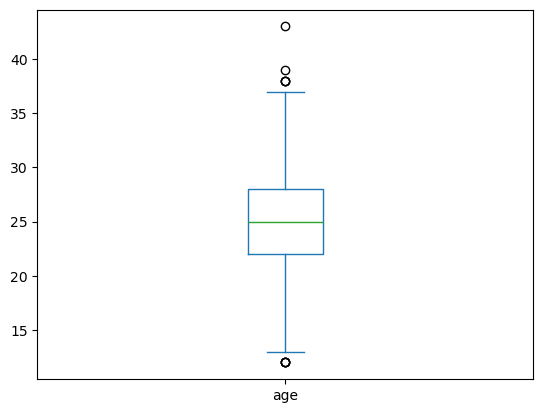

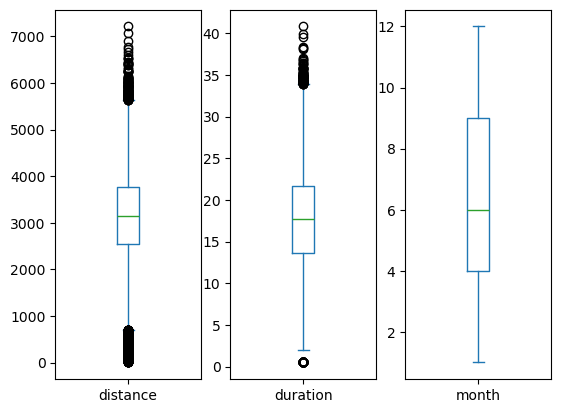

In [11]:
for df in dfs:
    df.drop('user_id', axis=1).plot(kind='box', subplots=True)

Значения за границами ящика с усами не противоречат логике и могут быть оставлены. Близкие к нулю значения переменных 'distance' и 'duration' могут помочь в анализе проблем с арендой самоката.

**Выводы**
- изменил тип данных переменных *users['subscription_type'], subscriptions['subscription_type'], rides['date']*;
- создал новый столбец users['month'] с номером месяца на основе столбца rides['date'];
- удалил явные дубликаты в users['user_id];
- проверил наличие неявных дубликатов и устранил их;
- после преобразований обновил индекс;
- проверил наличие аномальных значений и не обнаружил их.

### Исследовательский анализ данных

Опиcание и визуализация общей информации о пользователях и поездках:
- 3.1 частота встречаемости городов;
- 3.2 соотношение пользователей с подпиской и без подписки;
- 3.3 возраст пользователей;
- 3.4 расстояние, которое пользователь преодолел за одну поездку;
- 3.5 продолжительность поездок.

**Частота встречаемости городов**

In [12]:
# посчитал частоту встречаемости городов пользователей

users['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

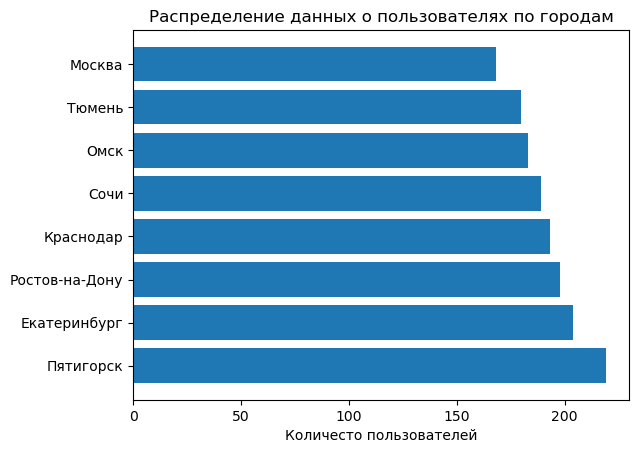

In [13]:
# построил линейчатую диаграмму для визуализации распределения данных о пользователях по городам

plt.barh(users['city'].value_counts().index, users['city'].value_counts())
plt.title('Распределение данных о пользователях по городам')
plt.xlabel('Количесто пользователей')
plt.show()

Данные были отобраны таким образом, чтобы распределение пользователей по городам было примерно равным — 11-14 %. В выборке больше всего пользователей из Екатеринбурга, а меньше всего — из Москвы.

**Соотношение пользователей с подпиской и без подписки**

In [14]:
# посчитал соотношение пользователей с подпиской и без подписки

users['subscription_type'].value_counts()

subscription_type
free     835
ultra    699
Name: count, dtype: int64

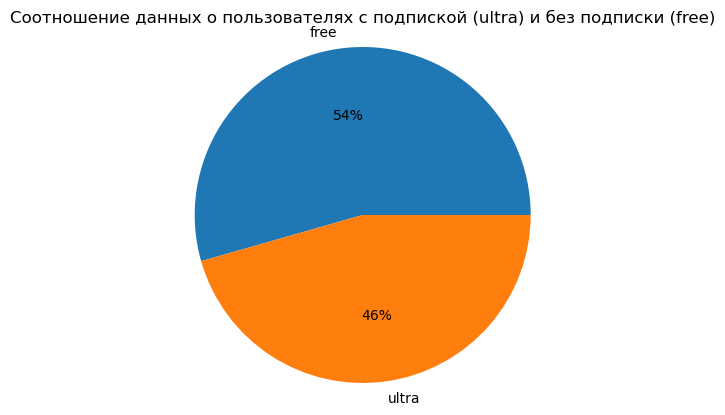

In [15]:
# построил круговую диаграмму для визуализации соотношения данных о пользователях с подпиской и без подписки

plt.pie(users['subscription_type'].value_counts(),
        labels=users['subscription_type'].value_counts().index,
        autopct='%1.f%%')
plt.axis('equal')
plt.title('Соотношение данных о пользователях с подпиской (ultra) и без подписки (free)')
plt.show()

Соотношение пользователей с подпиской и без подписки также оказалось примерно равным — 46 на 54 % соответственно.

**Возраст пользователей**

In [16]:
# вывел описательные статистики возраста пользователей

users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

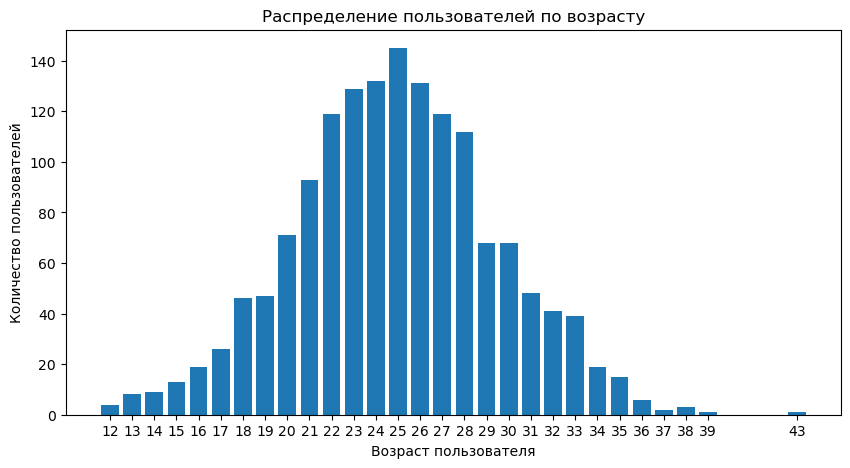

In [17]:
# построил столбчатую диаграмму для визуализации распределения пользователей по возрасту

plt.figure(figsize=(10, 5))
plt.bar(users['age'].value_counts().sort_index().index, users['age'].value_counts().sort_index().values)
plt.xlabel('Возраст пользователя')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по возрасту')
plt.xticks(users['age'].value_counts().sort_index().index)
plt.show()

Распределение пользователей по возрасту показало, что услугами GoFast каким-то образом могут пользоваться несовершеннолетние пользователи. Размах выборки равен 31 году, самому возрастному пользователю было 43 года. Распределение похоже на нормальное с ярко выраженными средним значением и медианой (25 лет). Стандартное отклонение 4.57 лет говорит об относительно маленьком разбросе данных вокруг среднего значения, то есть об относительное плотности распределения.

**Расстояние, которое пользователь преодолел за одну поездку**

In [18]:
# вывел описательные статистики расстояния поездок

rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

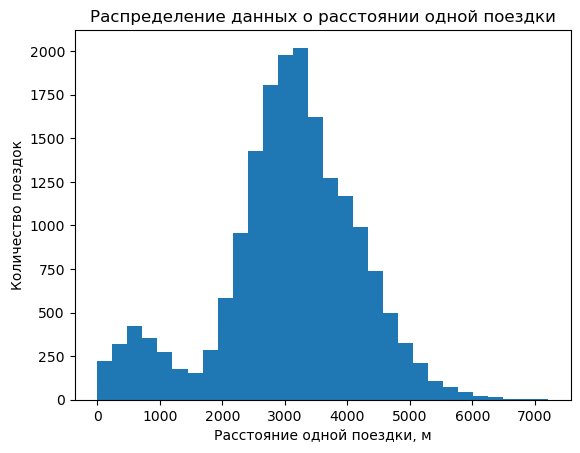

In [19]:
# построил гистограмму для распределния данных о расстоянии одной поездки

plt.hist(rides['distance'], bins=30)
plt.xlabel('Расстояние одной поездки, м')
plt.ylabel('Количество поездок')
plt.title('Распределение данных о расстоянии одной поездки')
plt.show()

Распределение поездок по расстоянию показало распределение, близкое к нормальному, но смещённое к малым значениям. Можно выделить два интервала: поездки на короткое расстояние (0, 1500) и поездки на длинное расстояние (1500, 7000).

Среднее значение (3071) и медиана (3134) достаточно близки, и меньшее среднее подтверждает гипотезу о смешённости данных влево. Самая длинная по расстоянию поездка равняется 7,21 км, а самая малая — 0 м (то есть решение о поездке было сразу же изменено, или возникли трудности с арендой самоката).

**Продолжительность поездок**

In [20]:
# вывел описательные статистики продолжительности поездок

rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

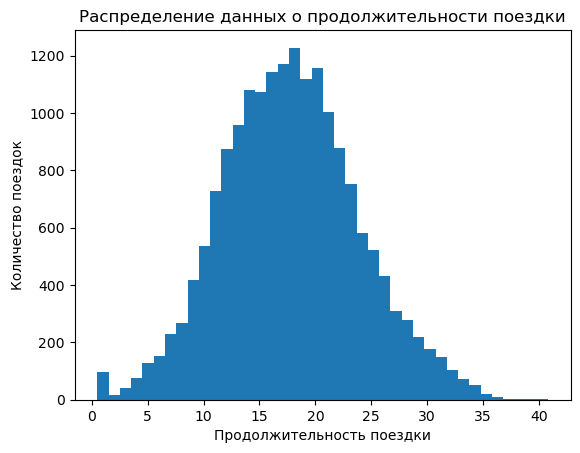

In [21]:
# построил гистограмму для распределния данных о продолжительности поездки

plt.hist(rides['duration'], bins=40)
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.title('Распределение данных о продолжительности поездки')
plt.show()

Распределение данных о продолжительности поездки близко к нормальному. Как и в данных о расстоянии поездок, при малых значениях, в интервале от 0 до 2 минут наблюдается локальный максимум, связанный предположительно с техническими трудностями при аренде самоката.

Средняя (17,8 минут) и медианная (17,7) продолжительность поездки примерно равны. Самая долгая по времени поездка равна 41 минуте.

**Выводы**

- Зафиксирован принцип формирования выборки по географическому принципу и по наличию подписки;
- Зафиксировано близкое к нормальное распредление непрерывных переменных, что позволяет продолжить анализ с выполнением теоретических предпосылок;
- Зафиксирована проблема, в которой нужно разбираться подробнее: короткие поездки до 2 минут или до 1500 м.

### Объединение данных

**Манипуляции с датафреймами**

In [22]:
# создал общий датафрейм

df = pd.merge(pd.merge(users, rides, on='user_id'), subscriptions, on='subscription_type')
df

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [23]:
# разделил датафрейм по наличию/отсутствию подписки

df_free = df[df['subscription_type'] == 'free']
df_ultra = df[df['subscription_type'] == 'ultra']

**Сравнение даннных по длительности и расстоянию поездок в зависимости от наличия/отсутствия подписки**

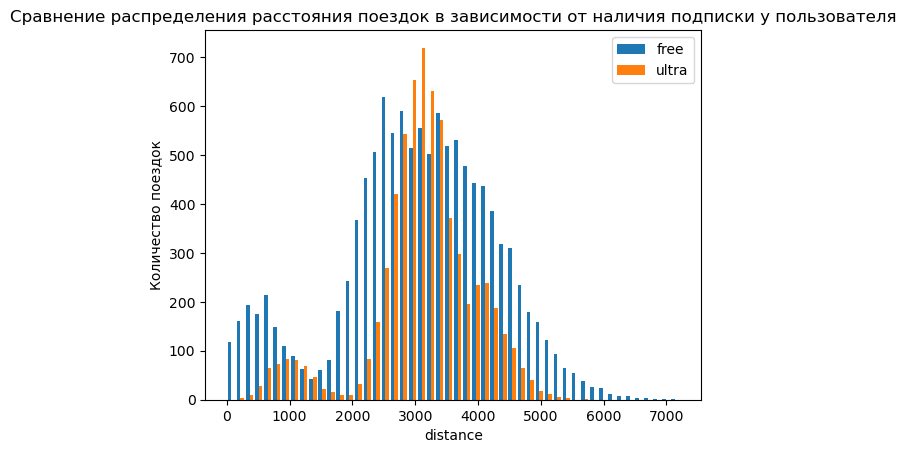

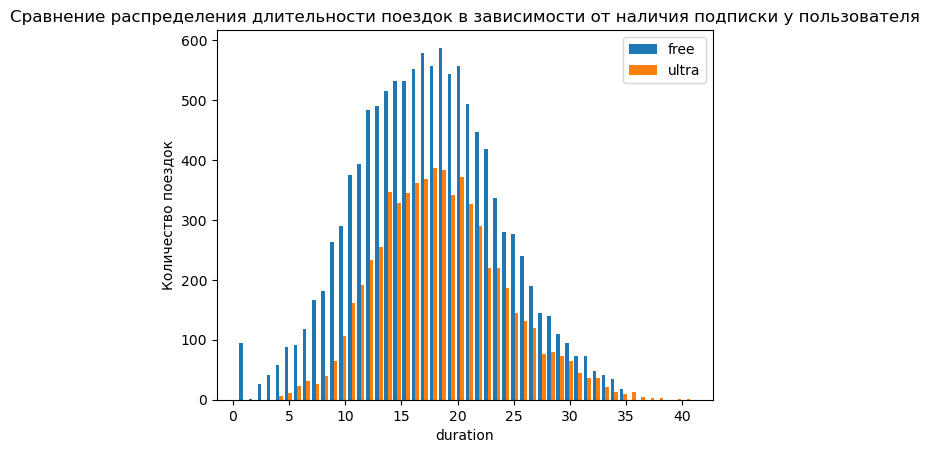

,free — distance,ultra — distance,free — duration,ultra — duration
count,11568.000000,6500.000000,11568.000000,6500.000000
mean,3045.495282,3115.445388,17.390909,18.541985
std,1246.173806,836.895330,6.326803,5.572048
min,0.855683,244.210438,0.500000,3.760353
25%,2366.562689,2785.444017,12.958437,14.524654
50%,3114.648465,3148.637229,17.326890,18.178153
75%,3905.697894,3560.574425,21.594071,21.884129
max,7211.007745,5699.769662,34.948498,40.823963


In [24]:
# создал списки для оптимизации кода
columns = ['distance', 'duration']
titles = ['Сравнение распределения расстояния поездок в зависимости от наличия подписки у пользователя',
          'Сравнение распределения длительности поездок в зависимости от наличия подписки у пользователя']
subscription_types = ['free', 'ultra']

# создал пустой датафрейм для удобного вывода описательных статистик
describe_df = pd.DataFrame()

# создал цикл для построения гистограммы и вывода описательных статистик
for column in columns:
    for subscription in subscription_types:
        
        # создал развилку в зависимости от наличия/отсутствия подписки у пользователя
        df_to_choose = df_free if subscription == 'free' else df_ultra

        # получил описательные статистики для текущего статуса подписки у пользователя
        describe_output = df_to_choose[column].describe().rename(f'{subscription} — {column}')

        # добавил описательные статистики в пустой датафрейм
        describe_df = pd.concat([describe_df, describe_output], axis=1)

    # создал список переменных для гистограммы
    data = [df_free[column], df_ultra[column]]

    # построил гистограмму
    plt.hist(data, bins=50, label=subscription_types)
    plt.xlabel(column)
    plt.ylabel('Количество поездок')
    plt.title(titles[columns.index(column)])
    plt.legend()
    plt.show()

describe_df

**Выводы**
- В данных о расстоянии поездок пользователей с подпиской заметно более плотное распределение, меньшее стандартное отклонение и однозначно определённая мода, что может говорить о соответствии целей, для которых подписка была куплена, реальному использованию подписки. То есть пользователь мог предполагать, что будет ездить на расстояние от 2000 до 5000 м, и поэтому затраты на подписку окупятся. С другой стороны, при налчии подписки пользователь может чаще предпочитать GoFast другим компаниям или видам транспорта, чтобы "оправдать" затраты на подписку;
- На поездках с расстоянием менее 2000 м заметны паттерны поведения пользователей:
 - пользователи с подпиской не катаются на расстояния меньше 500 м, а пользователи без подписки, в том числе новые пользователи, пробуют самокат GoFast на коротких расстояних;
 - независимо от наличия подписки, пользователи используют самокат для коротких и для длинных поездок. Для пользователей без подписки, длинные поездки начинаются с отметки 1500 м; для пользователей с подпиской — с 2000 м;
 - несмотря на наличие подписки, её обладатели почти не катаются на расстояние более 5000 м. Пользователи без подписки чаще катаются на такие расстояния;
- В данных о длительности поездок наличие подписки не влияет на распределения — они очень похожи;
- У пользователей без подписки заметно большое количество поездок менее 2 минут, что говорит об их трудностях с арендой самоката или с управлением им.

### Подсчёт выручки

**Создание датафрейма с агрегированными данными о поездках на основе общего датафрейма**

In [25]:
# округлим в большую сторону длительность поездок в объединённом датафрейме

df['duration'] = np.ceil(df['duration']) 

In [26]:
new_df = (df.groupby(['user_id', 'month'])
          .agg({'user_id': 'count',
                'distance': 'sum',
                'duration': 'sum',
                'name': 'first',
                'age': 'first',
                'city': 'first',
                'subscription_type': 'first',
                'minute_price': 'first',
                'start_ride_price': 'first',
                'subscription_fee': 'first'})
          .rename(columns={'user_id': 'rides_count',
                           'distance': 'distance_sum',
                           'duration': 'duration_sum'})
          .reset_index())
new_df

,user_id,month,rides_count,distance_sum,duration_sum,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42.0,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7.0,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46.0,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32.0,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56.0,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,Альберт,25,Краснодар,free,8,50,0
11327,1534,8,2,7622.453034,48.0,Альберт,25,Краснодар,free,8,50,0
11328,1534,9,1,4928.173852,23.0,Альберт,25,Краснодар,free,8,50,0
11329,1534,11,4,13350.015305,78.0,Альберт,25,Краснодар,free,8,50,0


**Добавление расчётного столбца с помесячной выручкой**

Помесячная выручка =
<br> стоимость старта поездки ×  количество поездок
<br>+
<br>стоимость одной минуты поездки × общая продолжительность всех поездок в минутах)
<br>+
<br>стоимость подписки

In [27]:
# создал новый столбец в соответствии с требованиями

new_df['monthly_revenue'] = ((new_df['start_ride_price'] * new_df['rides_count'])
                             + (new_df['minute_price'] * new_df['duration_sum'])
                             + new_df['subscription_fee'])
new_df

,user_id,month,rides_count,distance_sum,duration_sum,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_revenue
0,1,1,2,7027.511294,42.0,Кира,22,Тюмень,ultra,6,0,199,451.0
1,1,4,1,754.159807,7.0,Кира,22,Тюмень,ultra,6,0,199,241.0
2,1,8,2,6723.470560,46.0,Кира,22,Тюмень,ultra,6,0,199,475.0
3,1,10,2,5809.911100,32.0,Кира,22,Тюмень,ultra,6,0,199,391.0
4,1,11,3,7003.499363,56.0,Кира,22,Тюмень,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,2,3409.468534,26.0,Альберт,25,Краснодар,free,8,50,0,308.0
11327,1534,8,2,7622.453034,48.0,Альберт,25,Краснодар,free,8,50,0,484.0
11328,1534,9,1,4928.173852,23.0,Альберт,25,Краснодар,free,8,50,0,234.0
11329,1534,11,4,13350.015305,78.0,Альберт,25,Краснодар,free,8,50,0,824.0


**Выводы**

Агрегированная таблица создана и расчётный столбец с выручкой по месяцам добавлен.

### Проверка гипотез

Аргумент 'greater' может использоваться для проверки альтернативной гипотезы «Среднее значение первой генеральной совокупности больше среднего значения второй генеральной совокупности». Аргумент 'less' может использоваться для проверки альтернативной гипотезы «Среднее значение первой генеральной совокупности меньше среднего значения второй генеральной совокупности».

In [28]:
# уровень статистической значимости для тестов

alpha = 0.05

**Гипотеза №1**

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверьте гипотезу. Используйте исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

Н0: cреднее время поездки у пользователей с подпиской = cреднее время поездки у пользователей без подписки
<br>H1: cреднее время поездки у пользователей с подпиской > cреднее время поездки у пользователей без подписки

In [29]:
print('Н0: cреднее время поездки у пользователей с подпиской = cреднее время поездки у пользователей без подписки')
print('H1: cреднее время поездки у пользователей с подпиской > cреднее время поездки у пользователей без подписки', '\n')

h1 = st.ttest_ind(df_ultra['duration'],
                  df_free['duration'],
                  equal_var=False,
                  alternative='greater')

print("mean df_ultra['duration']:", df_ultra['duration'].mean())
print("mean df_free['duration']:", df_free['duration'].mean())
print('p-value:', h1.pvalue, '\n')

if h1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Н0: cреднее время поездки у пользователей с подпиской = cреднее время поездки у пользователей без подписки
H1: cреднее время поездки у пользователей с подпиской > cреднее время поездки у пользователей без подписки 

mean df_ultra['duration']: 18.54198516280583
mean df_free['duration']: 17.39090929866399
p-value: 5.6757813771289775e-37 

Отвергаем нулевую гипотезу


Вероятность ошибиться, отвергнув нулевую гипотезу при том, что она верна, мала (p-value < 5%). Следовательно, можем уверенно сказать, что среднее время поездки у пользователей с подпиской больше.

**Гипотеза №2**

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверьте гипотезу и сделайте выводы.

Н0: cреднее расстояние поездки у пользователей с подпиской = 3130 м
<br>H1: cреднее расстояние поездки у пользователей с подпиской > 3130 м

In [30]:
print('Н0: cреднее расстояние поездки у пользователей с подпиской = 3130 м')
print('H1: cреднее расстояние поездки у пользователей с подпиской > 3130 м', '\n')

h2_goal = 3130

h2 = st.ttest_1samp(df_ultra['distance'], h2_goal, alternative='greater')

print("mean df_ultra['distance']:", df_ultra['distance'].mean())
print("mean df_free['distance']:", df_free['distance'].mean())
print('p-value:', h2.pvalue, '\n')

if h2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Н0: cреднее расстояние поездки у пользователей с подпиской = 3130 м
H1: cреднее расстояние поездки у пользователей с подпиской > 3130 м 

mean df_ultra['distance']: 3115.4453880370247
mean df_free['distance']: 3045.495281671816
p-value: 0.9195368847849785 

Не отвергаем нулевую гипотезу


Вероятность ошибиться, отвергнув нулевую гипотезу при том, что она верна, высока (p-value > 5%). Следовательно, расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

**Гипотеза №3**

Проверьте гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Сделайте вывод.

Н0: cредняя выручка от пользователей с подпиской = cредняя выручка от пользователей без подписки
<br>H1: cредняя выручка от пользователей с подпиской > cредняя выручка от пользователей без подписки

In [31]:
print('Н0: cредняя выручка от пользователей с подпиской = cредняя выручка от пользователей без подписки')
print('H1: cредняя выручка от пользователей с подпиской > cредняя выручка от пользователей без подписки', '\n')

h3 = st.ttest_ind(new_df[new_df['subscription_type'] == 'ultra']['monthly_revenue'],
                  new_df[new_df['subscription_type'] == 'free']['monthly_revenue'],
                  equal_var=False,
                  alternative='greater')

print("new_df[new_df['subscription_type'] == 'ultra']['monthly_revenue'].mean():", new_df[new_df['subscription_type'] == 'ultra']['monthly_revenue'].mean())
print("new_df[new_df['subscription_type'] == 'ultra']['monthly_revenue'].mean():", new_df[new_df['subscription_type'] == 'free']['monthly_revenue'].mean())
print('p-value:', h3.pvalue, '\n')

if h3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

Н0: cредняя выручка от пользователей с подпиской = cредняя выручка от пользователей без подписки
H1: cредняя выручка от пользователей с подпиской > cредняя выручка от пользователей без подписки 

new_df[new_df['subscription_type'] == 'ultra']['monthly_revenue'].mean(): 362.7921906022502
new_df[new_df['subscription_type'] == 'ultra']['monthly_revenue'].mean(): 328.6413651073845
p-value: 8.874140893976874e-40 

Отвергаем нулевую гипотезу


Вероятность ошибиться, отвергнув нулевую гипотезу при том, что она верна, мала (p-value < 5%). Следовательно, можем уверенно утверждать, что средняя выручка от пользователей с подпиской больше средней выручки от пользователей без подписки.

**Гипотеза №4**

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

Ответ:

Чтобы проверить гипотезу о равенстве среднего генеральной совокупности для зависимых (парных) выборок, нам понадобиться тест *ttest_rel()*.

(необязательное задание)

### Выводы

В результате исследования были выполнены следующие задачи:

1. **Подготовлены данные к анализу**
    - дубликаты обработаны
    - статистические выбросы обнаружены и учтены в исследовании
2. **Исследованы закономоерности данных**
    - распределение пользователей по городам:
    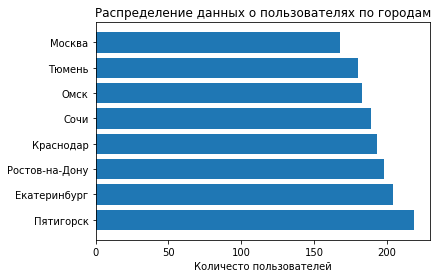 Данные были отобраны таким образом, чтобы распределение пользователей по городам было примерно равным — 11-14 %. В выборке больше всего пользователей из Екатеринбурга, а меньше всего — из Москвы.
    - распределение пользователей с подпиской и без подписки:
    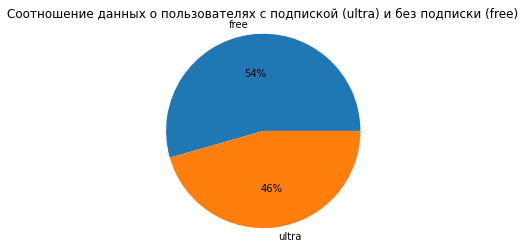 Соотношение пользователей с подпиской и без подписки также оказалось примерно равным — 46 на 54 % соответственно.
    - распределение пользователей по возрасту:
    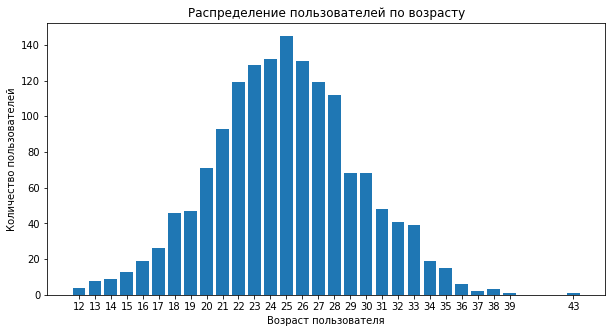 Распределение пользователей по возрасту показало, что услугами GoFast каким-то образом могут пользоваться несовершеннолетние пользователи. Размах выборки равен 31 году, самому возрастному пользователю было 43 года. Распределение похоже на нормальное с ярко выраженными средним значением и медианой (25 лет). Стандартное отклонение 4.57 лет говорит об относительно маленьком разбросе данных вокруг среднего значения, то есть об относительное плотности распределения.
    - распределение данных о расстоянии одной поездки:
    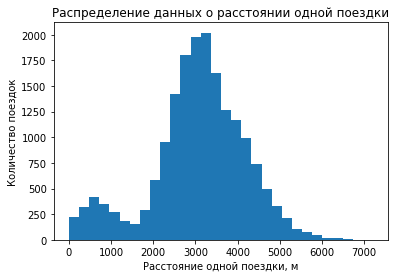 Распределение поездок по расстоянию показало распределение, близкое к нормальному, но смещённое к малым значениям. Можно выделить два интервала: поездки на короткое расстояние (0, 1500) и поездки на длинное расстояние (1500, 7000).
    <br>Среднее значение (3071) и медиана (3134) достаточно близки, и меньшее среднее подтверждает гипотезу о смешённости данных влево. Самая длинная по расстоянию поездка равняется 7,21 км, а самая малая — 0 м (то есть решение о поездке было сразу же изменено, или возникли трудности с арендой самоката).
    <br>Пик в поездках до 1500 м может включать поездки от остановки общественного транспорта до дома или от дома до метро (для Москвы и Екатеринбурга). А если расстояние большое, то можно выбрать общественный транспорт — и дешевле будет.
    Можно предположить, что в части выборки (1500, 7000) пользователи самокатов больше "отдыхают", а в части выборки (0, 1500) пользователи куда-то спешат.
    - распределение данных о продолжительности одной поездки:
    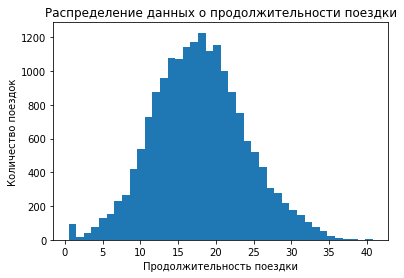 Распределение данных о продолжительности поездки близко к нормальному. Как и в данных о расстоянии поездок, при малых значениях, в интервале от 0 до 2 минут наблюдается локальный максимум, связанный предположительно с техническими трудностями при аренде самоката.
    Средняя (17,8 минут) и медианная (17,7) продолжительность поездки примерно равны. Самая долгая по времени поездка равна 41 минуте.
    
3. **Объединены данные в один датафрейм для ответа на вопросы бизнеса**
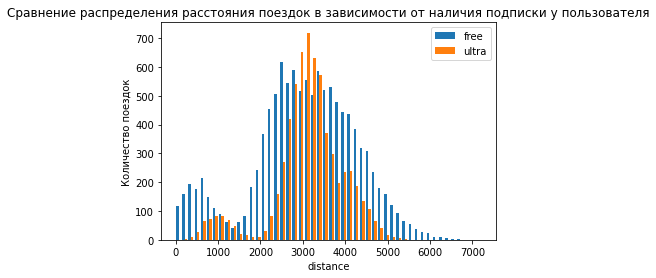 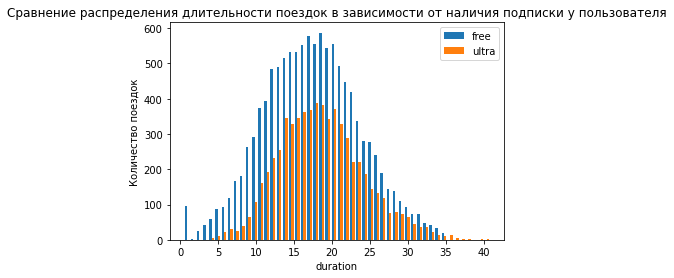
- В данных о расстоянии поездок пользователей с подпиской заметно более плотное распределение, меньшее стандартное отклонение и однозначно определённая мода, что может говорить о соответствии целей, для которых подписка была куплена, реальному использованию подписки. То есть пользователь мог предполагать, что будет ездить на расстояние от 2000 до 5000 м, и поэтому затраты на подписку окупятся. С другой стороны, при налчии подписки пользователь может чаще предпочитать GoFast другим компаниям или видам транспорта, чтобы "оправдать" затраты на подписку;
- На поездках с расстоянием менее 2000 м заметны паттерны поведения пользователей:
 - пользователи с подпиской не катаются на расстояния меньше 500 м, а пользователи без подписки, в том числе новые пользователи, пробуют самокат GoFast на коротких расстояних;
 - независимо от наличия подписки, пользователи используют самокат для коротких и для длинных поездок. Для пользователей без подписки, длинные поездки начинаются с отметки 1500 м; для пользователей с подпиской — с 2000 м;
 - несмотря на наличие подписки, её обладатели почти не катаются на расстояние более 5000 м. Пользователи без подписки чаще катаются на такие расстояния;
- В данных о длительности поездок наличие подписки не влияет на распределения — они очень похожи;
- У пользователей без подписки заметно большое количество поездок менее 2 минут, что говорит об их трудностях с арендой самоката или с управлением им.
    
4. **Проверены статистические гипотезы о данных**
<br>Были сделаны следующие выводы на основе AB-тестов:
- среднее время поездки у пользователей с подпиской больше;
- расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров;
- средняя выручка от пользователей с подпиской больше средней выручки от пользователей без подписки.